# CS 1656 – Introduction to Data Science (Spring 2020) 

## Instructor: Alexandros Labrinidis and Evangelos Karageorgos /Teaching Assistant: Xiaoting Li

## Term Project 

**Released: March 23, 2020**

**Due: April 21, 2020**

In [1]:
# Your name: <Sarah Hawbaker>
# Your github ID: <sah129>
# Your pitt username: <sah129>

### Goal
The goal of this project is to expose you with a real data science problem, looking at the end-to-end pipeline. 

### What to do 
You are asked to write a Python Jupyter notebook, called `pgh_bike.ipynb` that will:
* [Task 1] access historical bike rental data for 2019 from HealthyRidePGH and summarize the rental data  
* [Task 2] create graphs to show the popularity of the different rental stations, given filter conditions  
* [Task 3] create graphs to show the rebalancing issue  
* [Task 4] cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.  

**Your program should not take more than 15 minutes to run**

### Jupyter Notebook Rules
This skeleton is provided for you to complete the project. Please add your code in the code cells below each Task. Feel free to add cells as needed. Do not remove existing cells.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import datetime
import numpy as np

For the sake of interactive display in Jupyter, we will enable matplotlib inline.

In [3]:
%matplotlib inline

### [Task 0] Warming Up
Task 0 is for testing. It is used to ensure that this Jupyter Notebook skeleton works on both your machines and our machine. Please run the following code to see if you can see a line plot. The line plot is the basic plot that we have seen in Recitation2. 

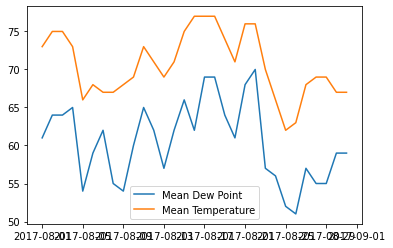

In [4]:
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
df = pd.read_csv('http://data.cs1656.org/KPIT_Aug17.csv',\
                       sep=',', engine='python', parse_dates=['EST'])
p1 = plt.plot(df['EST'],df['MeanDew PointF'])
p2 = plt.plot(df['EST'],df['Mean TemperatureF'])
plt.legend([p1[0],p2[0]], ['Mean Dew Point', 'Mean Temperature'])

plt.show()

--- 
Add your code below this line

---
### Task 1

In this task you will need to access historical bike rental data for 2019 from HealthyRidePGH and summarize the rental data.

### Task 1.1

In [5]:
filename_q1 = "HealthyRideRentals2019-Q1.csv"
filename_q2 = "HealthyRideRentals2019-Q2.csv"
filename_q3 = "HealthyRideRentals2019-Q3.csv"
#dummy_set = "dummy_set_100.csv"

In [11]:
df = pd.concat([pd.read_csv(filename_q1, dtype = {'From station id':'string', 'To station id':'string'}),pd.read_csv(filename_q2,dtype = {'From station id':'string', 'To station id':'string'}),pd.read_csv(filename_q3, dtype = {'From station id':'string', 'To station id':'string'})], axis = 0)
df = df[["Starttime", "Bikeid", "From station id", "To station id"]] #subset of relevant data
df["Starttime"] = pd.to_datetime(df["Starttime"]) #convert to datetime object

In [212]:
df = df.dropna(subset=["From station id", "To station id"], how='all')  #drop row if both from station and to station is <NA>, these are dockless bikes
df = df.set_index(pd.DatetimeIndex(df["Starttime"].values))

In [213]:
fromcnt = df.groupby("From station id").resample('H')['From station id'].count().rename("fromCNT")
tocnt = df.groupby("To station id").resample('H')['To station id'].count().rename("toCNT")
counts_hr = pd.concat([fromcnt, tocnt], axis = 1)
counts_hr.fillna(0, inplace = True)
counts_hr["rebalCNT"] = 0
counts_hr.index.names = ["Station id", "Startdate"]

In [214]:
def rebalance(group):
        prev = group["From station id"].iloc[0]  # handle if first is <NA>
        for d in zip(group["From station id"], group["To station id"], group["Starttime"]): #.iloc[1:]:
            if(pd.notna(d[0])):  #If From station id is not <NA>, then see if it To station id on row above it
                if( d[0] != prev):   
                    #print(f'Mismatch: From: {d[0]}, prev: {prev}, bikeid: {group.name}, Startdate: {d[2].date()}')
                    counts.loc[(d[0],d[2].date()), "rebalCNT"] +=1
            if(pd.notna(d[1])): #If To station id IS <NA>, then the previous row's From station id will remain in d[1].  This works because we have eliminated all rows where From and To are both <NA>
                prev = d[1]
       

In [215]:
counts = counts_hr.groupby("Station id").resample('D', level = 1).sum()
counts["rebalCNT"] = 0 # Just to make sure all counts are reset during testing
df.sort_values(["Bikeid", "Starttime"]).groupby("Bikeid").apply(rebalance)

""


In [216]:
counts.head(20)

fromCNT  toCNT  rebalCNT
Station id Startdate                           
1000       2019-01-01      4.0    4.0       0.0
           2019-01-02      2.0    0.0       0.0
           2019-01-03      0.0    3.0       0.0
           2019-01-04      2.0    1.0       0.0
           2019-01-05      5.0    5.0       0.0
           2019-01-06      1.0    2.0       0.0
           2019-01-07      2.0    2.0       0.0
           2019-01-08      2.0    1.0       0.0
           2019-01-09      2.0    0.0       0.0
           2019-01-10      1.0    1.0       0.0
           2019-01-11      1.0    0.0       0.0
           2019-01-12      0.0    2.0       0.0
           2019-01-13      0.0    1.0       0.0
           2019-01-14      0.0    1.0       0.0
           2019-01-15      3.0    6.0       0.0
           2019-01-16      1.0    0.0       0.0
           2019-01-17      0.0    3.0       0.0
           2019-01-18      2.0    0.0       0.0
           2019-01-19      3.0    1.0       0.0
           2019-01-20      0.0    0.0       0.0

### Task 1.2

In [217]:
mcounts = counts.groupby("Station id").resample('M', level = 1).sum()
mcounts.head(20)

fromCNT  toCNT  rebalCNT
Station id Startdate                           
1000       2019-01-31     35.0   43.0       1.0
           2019-02-28     51.0   58.0      11.0
           2019-03-31    132.0  174.0      11.0
           2019-04-30    392.0  434.0      10.0
           2019-05-31    601.0  654.0      34.0
           2019-06-30    666.0  719.0      36.0
           2019-07-31    672.0  693.0      29.0
           2019-08-31    586.0  640.0      18.0
           2019-09-30    522.0  564.0      16.0
1001       2019-01-31     59.0   82.0       1.0
           2019-02-28     61.0   80.0       4.0
           2019-03-31    117.0  134.0      14.0
           2019-04-30    276.0  332.0      17.0
           2019-05-31    429.0  500.0      12.0
           2019-06-30    498.0  522.0      31.0
           2019-07-31    552.0  605.0      74.0
           2019-08-31    470.0  539.0      10.0
           2019-09-30    415.0  462.0      20.0
1002       2019-01-31     36.0   28.0       7.0
           2019-02-28     51.0   48.0      11.0

---
### Task 2

In this task you will need to create graphs to show the popularity of the different rental stations, given filter conditions.

In [218]:
# FILTER VARIABLES -- feel free to edit the values, but the names of the variables must remain 
#                     as they are and should be used by your code accordingly from this point on

filter_month = 4
filter_stationID = 1046


### Task 2.1

In [219]:
filter_stationID = str(filter_stationID)
filter_month_label = datetime.date(mcounts.index.get_level_values("Startdate")[0].year, filter_month, 1).strftime('%B %Y')

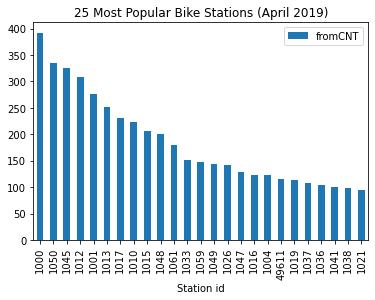

In [220]:
month_breakdown = mcounts[mcounts.index.get_level_values("Startdate").month == filter_month]
mb = month_breakdown.sort_values("fromCNT", ascending = False).reset_index()
mb = mb[['Station id', 'fromCNT']].head(25)
mb.plot(kind='bar', x = 'Station id', y = 'fromCNT')
plt.title(f'25 Most Popular Bike Stations ({filter_month_label})')
plt.show()

### Task 2.2

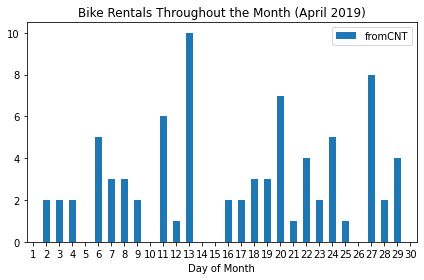

In [221]:
tt = counts[(counts.index.get_level_values("Startdate").month == filter_month) & (counts.index.get_level_values("Station id") == filter_stationID)].reset_index()
tt = tt[["Startdate", "fromCNT"]]
tt["Startdate"] = [x.day for x in tt["Startdate"]]
tt.plot(kind = 'bar', x = "Startdate", y = "fromCNT")
plt.title(f"Bike Rentals Throughout the Month ({filter_month_label})")
plt.xlabel("Day of Month")
plt.xticks(rotation = 'horizontal')
plt.tight_layout()
plt.show()

### Task 2.3

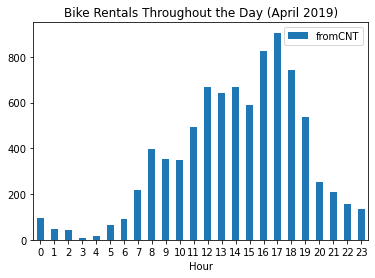

In [222]:
td = counts_hr[counts_hr.index.get_level_values("Startdate").month == filter_month].reset_index()
td = td.groupby(pd.DatetimeIndex(td['Startdate']).hour)['fromCNT'].sum().reset_index()
td.columns = ['Hour', 'fromCNT']
td.plot(kind = 'bar', x = "Hour", y = "fromCNT")
plt.xticks(rotation = 'horizontal')
plt.title(f"Bike Rentals Throughout the Day ({filter_month_label})")
plt.show()


### Task 2.4

In [223]:
daybcnt = df.groupby("Bikeid").resample('D')['Bikeid'].count().rename("bikeCNT")
mbcnt = daybcnt.groupby('Bikeid').resample('M', level = 1).sum().reset_index()
mbcnt.columns = ['Bikeid', 'Startdate', 'bikeCNT']
mbcnt = mbcnt.set_index(["Bikeid", "Startdate"])

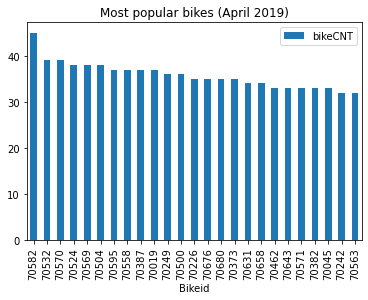

In [224]:
bmonth_breakdown = mbcnt[mbcnt.index.get_level_values("Startdate").month == filter_month]
mbb = bmonth_breakdown.sort_values("bikeCNT", ascending = False).reset_index()
mbb = mbb[['Bikeid', 'bikeCNT']].head(25)
mbb.plot(kind='bar', x = 'Bikeid', y = 'bikeCNT')
plt.title(f"Most popular bikes ({filter_month_label})")
plt.show()

---
### Task 3

In this task you will create graphs to show the rebalancing issue.

### Task 3.1

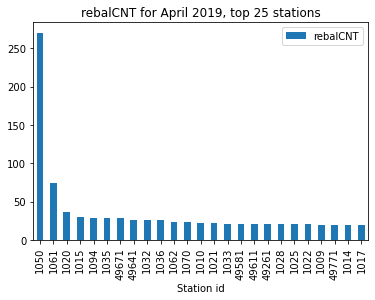

In [225]:
rbm = mcounts[mcounts.index.get_level_values("Startdate").month == filter_month].sort_values("rebalCNT", ascending = False).reset_index()
rbm = rbm[['Station id', 'rebalCNT']].head(25)
rbm.plot(kind='bar', x = 'Station id', y = 'rebalCNT')
plt.title(f"rebalCNT for {filter_month_label}, top 25 stations")
plt.show()  # 1050 is the Healthy Ride Hub

### Task 3.2

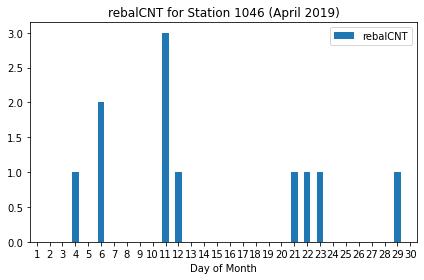

In [226]:
ttr = counts[(counts.index.get_level_values("Startdate").month == filter_month) & (counts.index.get_level_values("Station id") == filter_stationID)].reset_index()
ttr = ttr[["Startdate", "rebalCNT"]]
ttr["Startdate"] = [x.day for x in ttr["Startdate"]]
ttr.plot(kind = 'bar', x = "Startdate", y = "rebalCNT")
plt.title(f"rebalCNT for Station {filter_stationID} ({filter_month_label})")
plt.xticks(rotation = 'horizontal')
plt.xlabel("Day of Month")
plt.tight_layout()
plt.show()

---
### Task 4

In this task you will cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.

### Task 4.1

In [227]:
mcounts4 = mcounts[mcounts.index.get_level_values("Startdate").month >= 7]
mcounts4 = mcounts4[['fromCNT', 'rebalCNT']]
mcounts4 = mcounts4.unstack()
mcounts4.fillna(0, inplace = True)
mcounts4.columns = ["fromCNT 7", "fromCNT 8","fromCNT 9", "rebalCNT 7", "rebalCNT 8","rebalCNT 9"]

In [228]:
kmeans2 = KMeans(n_clusters=3).fit_predict(mcounts4)
kmeans4 = KMeans(n_clusters=4).fit_predict(mcounts4)
kmeans5 = KMeans(n_clusters=5).fit_predict(mcounts4)

db_params = [(10,2),(30,3),(40,8)]
dbscan1 = DBSCAN(eps=db_params[0][0], min_samples = db_params[0][1]).fit_predict(mcounts4)
dbscan2 = DBSCAN(eps=db_params[1][0], min_samples = db_params[1][1]).fit_predict(mcounts4)
dbscan3 = DBSCAN(eps=db_params[2][0], min_samples = db_params[2][1]).fit_predict(mcounts4)

### Task 4.2

In [229]:
kmeans_results = [kmeans2,kmeans4,kmeans5]
dbscan_results = [dbscan1, dbscan2, dbscan3]

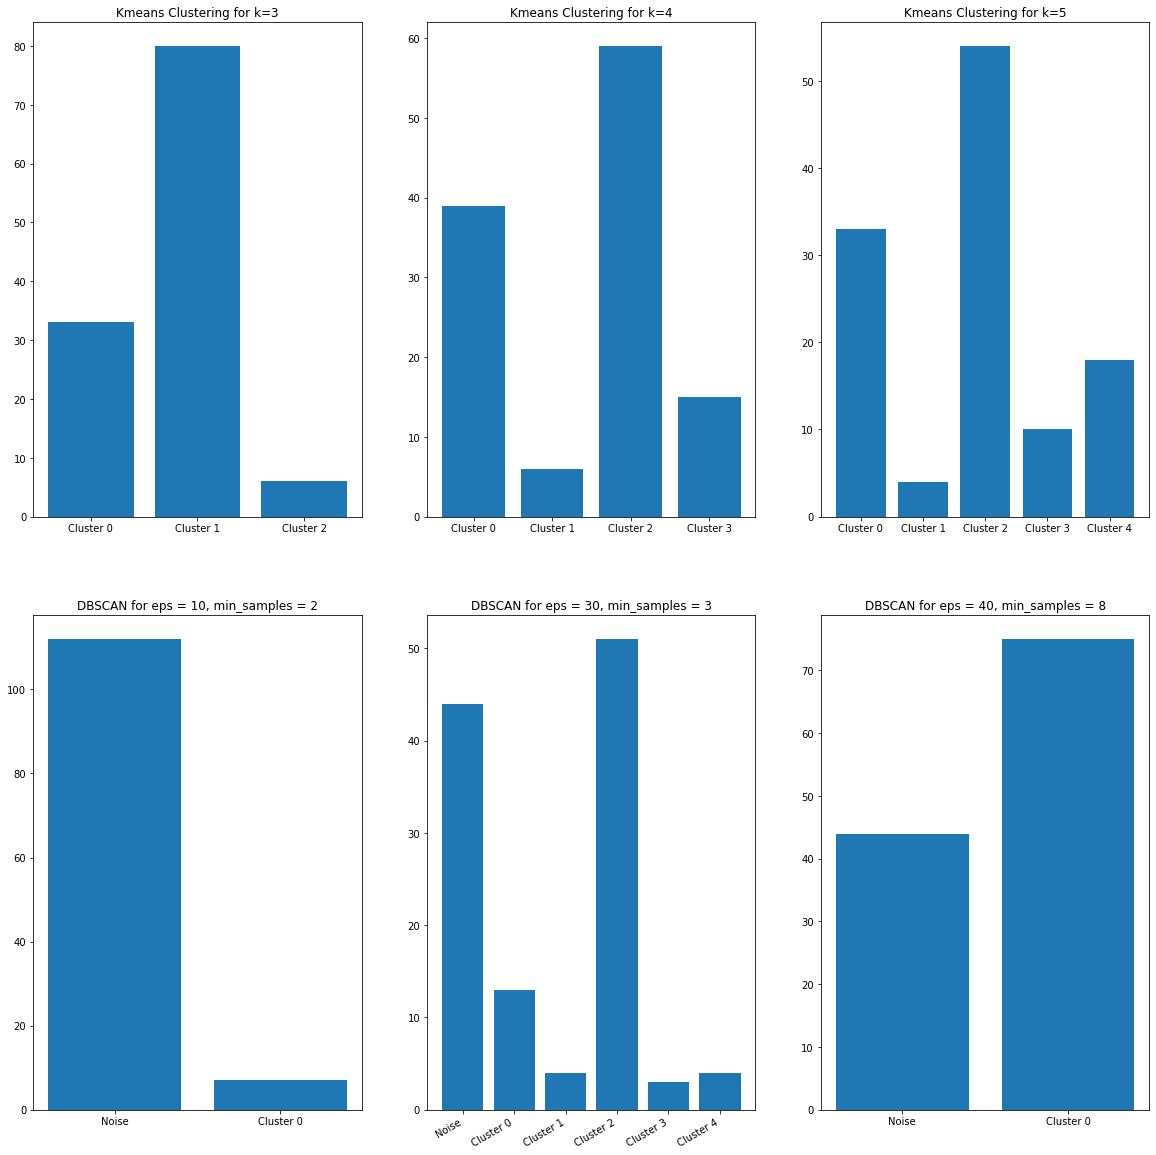

In [230]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,20))

for idx, val in enumerate(kmeans_results):
    vals = np.unique(val, return_counts = True)
    cluster_ids  = ["Cluster " + str(x) for x in vals[0]]
    axes[0,idx].bar(cluster_ids,vals[1])
    axes[0,idx].set_title("Kmeans Clustering for k=%d" % len(cluster_ids))
for idx, val in enumerate(dbscan_results):
    vals = np.unique(val, return_counts = True)
    cluster_ids  = ["Cluster " + str(x) for x in vals[0]]
    cluster_ids[0] = "Noise" #does unique always sort?
    axes[1,idx].bar(cluster_ids,vals[1])
    axes[1,idx].set_title(f'DBSCAN for eps = {db_params[idx][0]}, min_samples = {db_params[idx][1]}')
plt.setp(axes[1][1].get_xticklabels(), rotation=30, ha='right')


plt.show()

### Task 4.3

I used the silhouette score metric to examine many candidate values for K, trying values as low as 2 to as high as 50.  Generally the pattern was that as K increased the silhouette score decreased.  Occasionally this was not the case but any subsequent increases after K=2 were minimial.  I chose K=3, K=4, and K=5 as they had the highest silhouette scores (other than K=2), with K=3 being the highest at 0.5401.  However though K=4 has a slighly lower silhouette score, I think it is the best value I found as it had the least number of samples being given a score < 0, meaning the sample was possibly assigned to the wrong cluster.

I did not choose to include K=2 as the silhouette plot showed that one of the two clusters had below average silhouette scores.  K=3,K=4,K=5 had no clusters that fell below the average silhouette score, though some were close.  I could not find a result for any value of K in which the size of the clusters was evenly distributed.  K=3 and K=5 do have a small amount of samples that were possibly placed in the wrong cluster.  Below I have included the silhouette plots for my chosen values as well as 3 additional K values to illustrate the clustering results at more extreme values.

I think KMeans was a better algorithm to use with this data set. DBSCAN had a lot of difficulty forming more than 2 clusters with a significant portion of the points being labeled as noise.  The range for the eps parameter to return meaningful results was pretty small as well. Any value under 20 seemed to label almost all of the points as noise regardless of min_samples, but any values over 35 seemed to either group all points in one cluster, or have high noise levels and many small-sized clusters (less than 10 samples per cluster). 

Silhouette scores for almost all combinations of parameters were very low, typically < 0.02.  Silhouette scores were only comparable to the KMeans clustering results when the number of clusters detected was 1.  

I think KMeans performed better because DBSCAN can not handle clusters of varying densities.  Our dataset was probably more suited to KMeans because the distribution of bike usage at stations is widely uneven.  A station downtown might get a lot of traffic, whereas a station in Shadyside might get much less.  But both of these could reasonably be cluster centers. But with a fixed eps parameter in DBSCAN the lower fromCNTs/toCNTS could result in the Shadyside station being labeled as noise or included in the same cluster as the downtown station.  Time could have a similar effect, with warmer months seeing an increase in bike usage and colder months seeing a decrease.  

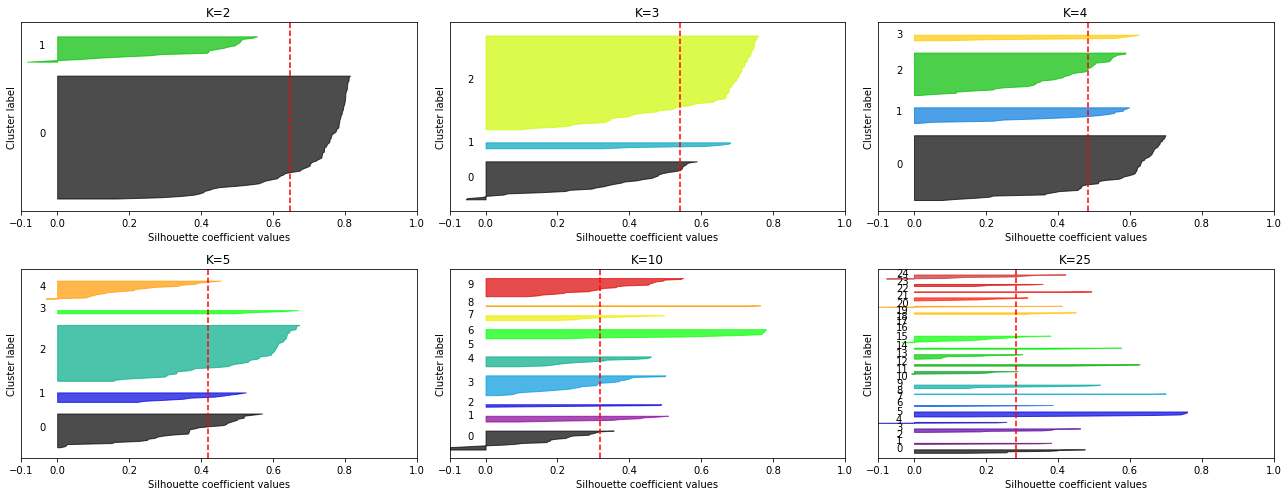

In [231]:
#Modified from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

random_state = 14 #for reproducible results
range_n_clusters = [2,3,4,5,10,25]
silhouette_scores = [None]*(len(range_n_clusters))
fig, ax = plt.subplots(2,3)
fig.set_size_inches(18, 7)
    
for idx, n_clusters in enumerate(range_n_clusters):
    ax1 = plt.subplot(2,3, idx +1)
    ax1.set_xlim([-0.1, 1]) 
    ax1.set_ylim([0, len(mcounts4) + (n_clusters + 1) * 10])    
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = clusterer.fit_predict(mcounts4)
    silhouette_avg = silhouette_score(mcounts4, cluster_labels)
    silhouette_scores[idx] = silhouette_avg
    sample_silhouette_values = silhouette_samples(mcounts4, cluster_labels)
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.set_title(f'K={n_clusters}')
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.tight_layout()
plt.show()

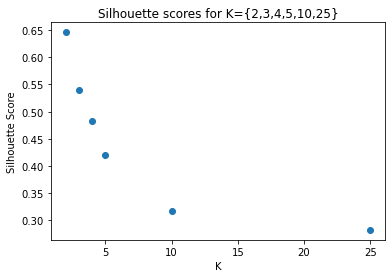

In [232]:
plt.scatter(range_n_clusters,silhouette_scores)
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title(f'Silhouette scores for K={{2,3,4,5,10,25}}')
plt.show()